In [19]:

import sys, subprocess

def ensure(pkg_import_name, pip_name=None):
    pip_name = pip_name or pkg_import_name
    try:
        __import__(pkg_import_name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name])


ensure("numpy", "numpy")
ensure("tensorflow", "tensorflow")          
ensure("sklearn", "scikit-learn")
ensure("matplotlib", "matplotlib")
ensure("pandas", "pandas")
ensure("IPython", "ipython")


try:
    ensure("xgboost", "xgboost")
except Exception:
    print("xgboost could not be installed; code will use GradientBoostingClassifier as fallback.")


In [20]:
import os, random, warnings, math
warnings.filterwarnings("ignore")

import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier
    XGB_AVAILABLE = False
    print("xgboost not found; using GradientBoostingClassifier as the fallback.")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


SEED = 123
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

ROOT       = os.getcwd()
TRAIN_DIR  = os.path.join(ROOT, "train")
VAL_DIR    = None       
TEST_DIR   = os.path.join(ROOT, "test")   
USE_SPLIT  = True       
IMG_SIZE   = 226
BATCH_SIZE = 32
EPOCHS     = 20
AUTOTUNE   = tf.data.AUTOTUNE


CLASS_NAMES = [
    "Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen",
    "Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse",
    "Small-flowered Cranesbill","Sugar beet"
]
print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.20.0


In [21]:
def list_class_folders(root, allowed):
    found = []
    for d in sorted(os.listdir(root)):
        p = os.path.join(root, d)
        if os.path.isdir(p) and d in allowed:
            found.append(d)
    if not found:
        raise RuntimeError(f"No valid class folders in {root}. Expected one or more of: {allowed}")
    return found

CLASS_NAMES = list_class_folders(TRAIN_DIR, CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)
print(f"Detected {NUM_CLASSES} classes:\n{CLASS_NAMES}")

def make_ds_from_directory(path, subset=None, validation_split=None, shuffle=True, seed=SEED):
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=CLASS_NAMES,         
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=seed,
        validation_split=validation_split,
        subset=subset,
    )

if USE_SPLIT or not VAL_DIR:
    train_ds = make_ds_from_directory(TRAIN_DIR, subset="training",   validation_split=0.20, shuffle=True)
    val_ds   = make_ds_from_directory(TRAIN_DIR, subset="validation", validation_split=0.20, shuffle=False)
else:
    train_ds = make_ds_from_directory(TRAIN_DIR, shuffle=True)
    val_ds   = make_ds_from_directory(VAL_DIR,   shuffle=False)

def prepare(ds, training=False):
    ds = ds.cache()
    if training: ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds,   training=False)

Detected 12 classes:
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Found 4750 files belonging to 12 classes.
Using 3800 files for training.
Found 4750 files belonging to 12 classes.
Using 950 files for validation.


# CNN

In [29]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.10),
        layers.RandomZoom(0.10),
    ],
    name="augment",
)

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("softmax")(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("softmax")(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("softmax")(x); x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    
    x = layers.Dense(256, activation="softmax", name="embedding")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="classifier")(x)
    return keras.Model(inputs, outputs, name="baseline_cnn")

cnn = build_cnn()
cnn.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
]

history = cnn.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 404s 3s/step - accuracy: 0.1297 - loss: 2.4676 - val_accuracy: 0.0000e+00 - val_loss: 2.4621 - learning_rate: 0.0010
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.1332 - loss: 2.4429 - val_accuracy: 0.0000e+00 - val_loss: 2.4532 - learning_rate: 0.0010
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - accuracy: 0.1632 - loss: 2.4287 - val_accuracy: 0.0000e+00 - val_loss: 2.4464 - learning_rate: 0.0010
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.2034 - loss: 2.4194 - val_accuracy: 0.0000e+00 - val_loss: 2.4480 - learning_rate: 0.0010
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.2166 - loss: 2.4105 - val_accuracy: 0.0000e+00 - val_loss: 2.4321 - learning_rate: 0.0010
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.2147 - loss: 2.3966 - val_accuracy: 0.0000e+00 - val_loss: 2.4003 - learning_rate: 0.0010
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - acc

In [30]:

def numpy_Conversion(ds):
    x_Values = []
    y_Values = []

    for x, y in ds:
        x_Values.append(x.numpy())
        y_Values.append(y.numpy())
    
    return np.concatenate(x_Values, 0), np.concatenate(y_Values, 0)

def labels_and_Pred(model, ds):
    y_Prob = model.predict(ds, verbose = 0)
    _, y_T_OneHot = numpy_Conversion(ds)
    y_T_Idx = np.argmax(y_T_OneHot, axis=1)
    y_Pred_Idx = np.argmax(y_Prob, axis=1)
    return y_T_Idx, y_Pred_Idx, y_Prob

def extract_features(ds, feature_model):
    features, labels = [], []
    for x, y in ds:
        z = feature_model.predict(x, verbose=0)
        features.append(z)
        labels.append(y.numpy())
    X = np.concatenate(features, 0)
    Y = np.concatenate(labels, 0)
    y_Idx = np.argmax(Y, axis=1)
    return X, y_Idx


def micro_roc_auc(y_T_Idx, y_Prob,num_Classes):
    y_T_Bin = label_binarize(y_T_Idx, classes=np.arange(num_Classes))
    n, m, _ = roc_curve(y_T_Bin.ravel(), y_Prob.ravel())
    return n, m, auc(n,m)


In [31]:
y_T_Val, y_Pred_Val_Cnn, y_Prob_Val_Cnn = labels_and_Pred(cnn, val_ds)
f1_Micro_Cnn_Val = f1_score(y_T_Val, y_Pred_Val_Cnn, average="micro")


feature_extractor = keras.Model(inputs=cnn.input, outputs=cnn.get_layer("embedding").output)
X_tr, y_tr = extract_features(train_ds, feature_extractor)
X_val, y_val = extract_features(val_ds, feature_extractor)


svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True, random_state=SEED))
svm_clf.fit(X_tr, y_tr)
y_pred_val_svm = svm_clf.predict(X_val)
y_prob_val_svm = svm_clf.predict_proba(X_val)
f1_micro_svm_val = f1_score(y_val, y_pred_val_svm, average="micro")


if XGB_AVAILABLE:
    xgb_clf = XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", num_class=NUM_CLASSES,
        eval_metric="mlogloss", tree_method="hist", random_state=SEED
    )
else:
    xgb_clf = GradientBoostingClassifier(random_state=SEED)

xgb_clf.fit(X_tr, y_tr)
y_pred_val_xgb = xgb_clf.predict(X_val)
y_prob_val_xgb = xgb_clf.predict_proba(X_val)
f1_micro_xgb_val = f1_score(y_val, y_pred_val_xgb, average="micro")
xgb_name = "XGBoost" if XGB_AVAILABLE else "GradientBoosting (fallback)"

print(f"Baseline CNN micro F1: {f1_Micro_Cnn_Val:.4f}")
print(f"CNN & SVM micro F1: {f1_micro_svm_val:.4f}")
print(f"CNN & {xgb_name:23} micro F1: {f1_micro_xgb_val:.4f}")


Baseline CNN micro F1: 0.1821
CNN & SVM micro F1: 0.6242
CNN & XGBoost                 micro F1: 0.9316


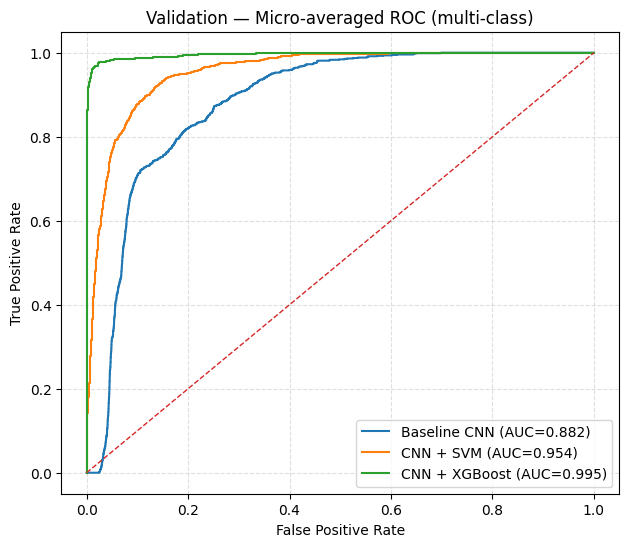

,Model,F1_micro VALUE,ROC_AUC_micro VALUE
2,CNN & XGBoost,0.931579,0.995219
1,CNN & SVM,0.624211,0.954019
0,Baseline CNN,0.182105,0.882009


In [32]:

fpr_cnn_v, tpr_cnn_v, auc_cnn_v = micro_roc_auc(y_T_Val, y_Prob_Val_Cnn, NUM_CLASSES)
fpr_svm_v, tpr_svm_v, auc_svm_v = micro_roc_auc(y_val, y_prob_val_svm, NUM_CLASSES)
fpr_xgb_v, tpr_xgb_v, auc_xgb_v = micro_roc_auc(y_val, y_prob_val_xgb, NUM_CLASSES)

plt.figure(figsize=(7.2,6))
plt.plot(fpr_cnn_v, tpr_cnn_v, label=f"Baseline CNN (AUC={auc_cnn_v:.3f})")
plt.plot(fpr_svm_v, tpr_svm_v, label=f"CNN + SVM (AUC={auc_svm_v:.3f})")
plt.plot(fpr_xgb_v, tpr_xgb_v, label=f"CNN + {xgb_name} (AUC={auc_xgb_v:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Validation — Micro-averaged ROC (multi-class)")
plt.legend(loc="lower right"); plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

display(pd.DataFrame({
    "Model": ["Baseline CNN", "CNN & SVM", f"CNN & {xgb_name}"],
    "F1_micro VALUE": [f1_Micro_Cnn_Val, f1_micro_svm_val, f1_micro_xgb_val],
    "ROC_AUC_micro VALUE": [auc_cnn_v, auc_svm_v, auc_xgb_v],
}).sort_values("F1_micro VALUE", ascending=False))


# Test set 

In [33]:
def load_unlabeled_images(folder: Path, img_size: int):
    files, imgs = [], []
    for p in sorted(folder.rglob("*.png")):
        if p.is_file():
            try:
                img = keras.utils.load_img(p, target_size=(img_size, img_size))
                arr = keras.utils.img_to_array(img)
                imgs.append(arr)
                files.append(p.name)
            except Exception as e:
                print(f"Skipping {p}: {e}")
    if not imgs:
        raise RuntimeError(f"No images found in {folder.resolve()}")
    return files, np.stack(imgs, 0).astype("float32")

TEST_DIR_PATH = Path(TEST_DIR)
files_test, Xtest = load_unlabeled_images(TEST_DIR_PATH, IMG_SIZE)
ds_unlab = tf.data.Dataset.from_tensor_slices(Xtest).batch(BATCH_SIZE).prefetch(AUTOTUNE)

prob_cnn_t = cnn.predict(ds_unlab, verbose=0)
pred_cnn_t = prob_cnn_t.argmax(1)
top_cnn_t = prob_cnn_t.max(1)

Ztest = feature_extractor.predict(ds_unlab, verbose=0)

prob_svm_t = svm_clf.predict_proba(Ztest)
pred_svm_t = prob_svm_t.argmax(1)
top_svm_t = prob_svm_t.max(1)

prob_xgb_t = xgb_clf.predict_proba(Ztest)
pred_xgb_t = prob_xgb_t.argmax(1)
top_xgb_t = prob_xgb_t.max(1)

model_tag = "XGBoost" if XGB_AVAILABLE else "GradientBoosting"
pred_df = pd.DataFrame({
    "file": files_test,
    "CNN_pred": [CLASS_NAMES[i] for i in pred_cnn_t],
    "CNN_conf": top_cnn_t,
    "SVM_pred": [CLASS_NAMES[i] for i in pred_svm_t],
    "SVM_conf": top_svm_t,
    f"{model_tag}_pred": [CLASS_NAMES[i] for i in pred_xgb_t],
    f"{model_tag}_conf": top_xgb_t,
}).sort_values("file").reset_index(drop=True)


print(f"\nPredictions generated for {len(files_test)} images in ./test")
display(pred_df)



Predictions generated for 794 images in ./test


,file,CNN_pred,CNN_conf,SVM_pred,SVM_conf,XGBoost_pred,XGBoost_conf
0,0021e90e4.png,Common Chickweed,0.237065,Common Chickweed,0.642280,Common Chickweed,0.757200
1,003d61042.png,Loose Silky-bent,0.211017,Fat Hen,0.803624,Fat Hen,0.979860
2,007b3da8b.png,Loose Silky-bent,0.156012,Fat Hen,0.538178,Sugar beet,0.523955
3,0086a6340.png,Common Chickweed,0.227114,Small-flowered Cranesbill,0.344117,Small-flowered Cranesbill,0.849846
4,00c47e980.png,Loose Silky-bent,0.156078,Fat Hen,0.495066,Fat Hen,0.503606
...,...,...,...,...,...,...,...
789,fea355851.png,Loose Silky-bent,0.265011,Loose Silky-bent,0.819544,Loose Silky-bent,0.978819
790,fea3da57c.png,Loose Silky-bent,0.149133,Sugar beet,0.479913,Sugar beet,0.833616
791,fef2ade8c.png,Loose Silky-bent,0.159944,Fat Hen,0.638301,Sugar beet,0.672301
792,ff65bc002.png,Charlock,0.274205,Charlock,0.915627,Charlock,0.994063


In [34]:
pred_df.describe()

,CNN_conf,SVM_conf,XGBoost_conf
count,794.000000,794.000000,794.000000
mean,0.218116,0.626013,0.784713
std,0.043352,0.163856,0.185540
min,0.116480,0.232961,0.247110
25%,0.183077,0.496770,0.631123
50%,0.225686,0.626433,0.845220
75%,0.252298,0.741654,0.949162
max,0.319346,0.972309,0.998580
